<a href="https://colab.research.google.com/github/graceful-coder/Personal-PredictETH-Submission/blob/main/LSTM_NeuralNetwork_PredictETH_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import plotly.express as px
import functools as ft
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import sklearn
import json
from pandas import json_normalize
from datetime import datetime
## For Long-short Term Memory Neural Network
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:
## SOURCE THE DATA

# Scrape hourly WETH close prices from on-chain data using Transpose SQL API.

headers = {
    'Content-Type': 'application/json',
    'X-API-KEY': 'pAqLbpC9x0tfW4ePTZdQOKqyfslA3Hya',
}

json_data = {
    'sql': "WITH price_series as(  SELECT * FROM (SELECT date_trunc('{{time_interval}}', timestamp) AS close_time FROM generate_series('{{start_date}}'::TIMESTAMP, now()::TIMESTAMP, '1 {{time_interval}}') timestamp ) time_series LEFT OUTER JOIN ( SELECT t1.price AS price, close_time_null FROM (SELECT MAX(timestamp) AS min_time, date_trunc('{{time_interval}}', timestamp) as close_time_null FROM ethereum.token_prices WHERE token_address = '{{token_address}}' AND timestamp >= '{{start_date}}' GROUP BY close_time_null ) hl_bars JOIN ethereum.token_prices t1 ON t1.timestamp = min_time AND t1.token_address = '{{token_address}}' ) AS ohlc ON time_series.close_time = ohlc.close_time_null ORDER BY time_series.close_time DESC ) SELECT close_time, coalesce(price, last_value(price) OVER (partition by _close_group ORDER BY close_time)) as price  FROM (SELECT close_time, price, count(price) OVER (order by close_time) as _close_group FROM price_series ) ohlc_fill ORDER BY close_time DESC;",
    'parameters': {
        'time_interval': 'h',
        'start_date': '20221001',
        'token_address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
    },
    'options': {},
}

response = requests.post('https://api.transpose.io/sql', headers=headers, json=json_data)

# See the json output
print(response.text)

{"status": "success", "stats": {"count": 3075, "size": 177935, "time": 359}, "results": [{"close_time": "2023-02-06T02:00:00Z", "price": 1630.7}, {"close_time": "2023-02-06T01:00:00Z", "price": 1631.76}, {"close_time": "2023-02-06T00:00:00Z", "price": 1639.25}, {"close_time": "2023-02-05T23:00:00Z", "price": 1629.63}, {"close_time": "2023-02-05T22:00:00Z", "price": 1634.29}, {"close_time": "2023-02-05T21:00:00Z", "price": 1622.67}, {"close_time": "2023-02-05T20:00:00Z", "price": 1619.58}, {"close_time": "2023-02-05T19:00:00Z", "price": 1619.85}, {"close_time": "2023-02-05T18:00:00Z", "price": 1616.21}, {"close_time": "2023-02-05T17:00:00Z", "price": 1618.81}, {"close_time": "2023-02-05T16:00:00Z", "price": 1639.59}, {"close_time": "2023-02-05T15:00:00Z", "price": 1644.9}, {"close_time": "2023-02-05T14:00:00Z", "price": 1651.98}, {"close_time": "2023-02-05T13:00:00Z", "price": 1648.4}, {"close_time": "2023-02-05T12:00:00Z", "price": 1648.34}, {"close_time": "2023-02-05T11:00:00Z", "pric

In [ ]:
## VISUALIZE THE DATA

# Convert the json to a dataframe
dict = json.loads(response.text)
df = json_normalize(dict["results"])
df = df.dropna()

# Convert the dates to Python datetime objects, cast the prices to float32 objects
df['close_time'] = pd.to_datetime(df['close_time'], format='%Y.%m.%d')
df['price'] = df['price'].astype('float32')

# Plot the hourly close price of WETH for reference
dates = np.array(df['close_time'])
prices = np.array(df['price'])

fig = px.line(x=dates,y=prices).update_layout(xaxis_title="Date", yaxis_title="WETH Price (USD)")
fig.show()

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [ ]:
# normalize the dataset from 0 to 1
df = df.drop('close_time', axis=1)
df = df.iloc[::-1]
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(df)

In [ ]:
# split into train and test sets 
# use 67% of the historical data for training, the remaining 33% for testing
train_size = int(len(normalized_dataset) * 0.67)
test_size = len(normalized_dataset) - train_size
train, test = normalized_dataset[0:train_size,:], normalized_dataset[train_size:len(normalized_dataset),:]
print(len(train), len(test))

2060 1015


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
2058/2058 - 88s - loss: 0.0237 - 88s/epoch - 43ms/step
Epoch 2/200
2058/2058 - 3s - loss: 3.4661e-04 - 3s/epoch - 1ms/step
Epoch 3/200
2058/2058 - 4s - loss: 2.7023e-04 - 4s/epoch - 2ms/step
Epoch 4/200
2058/2058 - 3s - loss: 2.7364e-04 - 3s/epoch - 2ms/step
Epoch 5/200
2058/2058 - 3s - loss: 2.7868e-04 - 3s/epoch - 1ms/step
Epoch 6/200
2058/2058 - 3s - loss: 2.8269e-04 - 3s/epoch - 1ms/step
Epoch 7/200
2058/2058 - 3s - loss: 2.7631e-04 - 3s/epoch - 1ms/step
Epoch 8/200
2058/2058 - 3s - loss: 2.7971e-04 - 3s/epoch - 1ms/step
Epoch 9/200
2058/2058 - 3s - loss: 2.7561e-04 - 3s/epoch - 1ms/step
Epoch 10/200
2058/2058 - 3s - loss: 2.7896e-04 - 3s/epoch - 1ms/step
Epoch 11/200
2058/2058 - 3s - loss: 2.8099e-04 - 3s/epoch - 1ms/step
Epoch 12/200
2058/2058 - 3s - loss: 2.7782e-04 - 3s/epoch - 1ms/step
Epoch 13/200
2058/2058 - 3s - loss: 2.8091e-04 - 3s/epoch - 1ms/step
Epoch 14/200
2058/2058 - 3s - loss: 2.8078e-04 - 3s/epoch - 1ms/step
Epoch 15/200
2058/2058 - 3s - loss: 2.8168e-

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

32/32 [==============================] - 0s 2ms/step
Train Score: 10.07 RMSE
Test Score: 8.52 RMSE


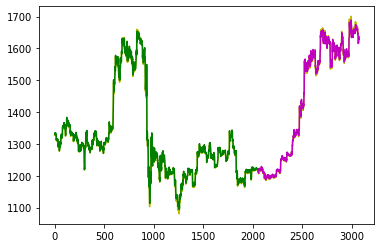

In [ ]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(normalized_dataset)-1, :] = testPredict

# plot baseline and predictions
allHistoricalValues = scaler.inverse_transform(normalized_dataset)
plt.plot(allHistoricalValues, 'y')
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'm')
plt.show()